In [1]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from functions import vac2air_ciddor
from scipy.interpolate import interp1d
from lmfit.models import VoigtModel
from edibles.utils.voigt_profile import voigt_absorption_line
from lmfit import Model
from edibles import PYTHONDIR
from edibles.utils.ContinuumFitter import ContinuumFitter
from edibles.utils.edibles_spectrum import EdiblesSpectrum
from edibles.utils.edibles_oracle import EdiblesOracle
import copy
import os.path
import warnings
from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_generic_continuum

In [2]:
def voigtUniPeak(peakData, sd = 1, plot = 2, retMod = False, base = 1, centre = None, sigma = None, amp = None):
    assert plot == 0 or plot == 1 or plot == 2, 'Please enter valid value for parameter plot (0, 1 or 2)'
    
    yForFit = base - peakData[:, 1]
    
    xForFit = copy.deepcopy(peakData[:, 0])
    mod = VoigtModel()
    params = mod.guess(yForFit, x = xForFit)
    params['center'].set(value = centre, vary = centre is None)
    params['sigma'].set(value = sigma, vary = sigma is None)
    params['amplitude'].set(value = amp, vary = amp is None)
    res = mod.fit(yForFit, params, x = xForFit, weights = 1/sd)
    
    if plot == 1:
        fig, ax = plt.subplots()
        ax.plot(xForFit, (base - res.best_fit), label = 'Voigt profile fit')
        ax.legend()
        fig.show()
    elif plot == 2:
        fig, ax = plt.subplots()
        ax.plot(xForFit, (base - yForFit), label = 'Data')
        ax.plot(xForFit, (base - res.best_fit), label = 'Voigt profile fit')
        ax.legend()
        fig.show()
    
    if retMod:
        return res
    else:
        return {'Centre': res.params['center'].value, 
                'FWHM': res.params['fwhm'].value, 
                'ChiSq': res.chisqr, 
                'RedChiSq': res.redchi}


In [2]:
#EDIBLES input parameters

#select molecule as follows -
# 2-Methylnaphthalene -> 1
# Acenaphthene -> 2
# Benzo[ghi]perylene -> 3
# Pentacene -> 4
# Perylene -> 5
# Phenanthrene -> 6
# Pyrene -> 7
# Phenalenyl -> 8
# Any other molecule -> 0 and input the molecule name (according to parameters file)

target = "HD 61827" #input space between 'HD' and starnumber

min_range = 3000     #minimum range of the sectrum
max_range = 5500     #maximum range of the sectrum
molno = 8            # molecule for analysis
#if you want to force edit cleaned up data file, change fEdit to 1, otherwise keep it to 0
fEdit1 = 0
#if you want to force edit final stacked data and image files, change fEdit to 1, otherwise keep it to 0
fEdit2 = 1

In [4]:
if molno == 1:
    mol = '2MethylNapthalene'
elif molno == 2:
    mol = 'Acenaphthene'
elif molno == 3:
    mol = 'Benzo_ghi_perylene'
elif molno == 4:
    mol = 'Pentacene'
elif molno == 5:
    mol = 'Perylene'
elif molno == 6:
    mol = 'Phenanthrene'
elif molno == 7:
    mol = 'Pyrene'
elif molno == 8:
    mol = 'Phenalenyl'
elif molno == 0:
    mol = input('Enter molecule file name (as in parameters file):\n')

In [5]:
params = "/home/devotosh01/Western_work/Work/Pentacene/"+mol+"Par.txt"
stack_par = np.loadtxt(params)
print(stack_par)


[[4.57739280e+03 3.87873605e+00]
 [4.77749820e+03 5.31845260e+00]
 [4.91843390e+03 2.28578053e+00]
 [4.93687360e+03 5.86282564e-01]
 [4.95745678e+03 5.08487348e-01]
 [4.97969849e+03 1.63467075e+00]
 [5.00080242e+03 6.62956180e-01]
 [5.03049217e+03 5.19665600e-01]
 [5.05351791e+03 6.75949666e-01]
 [5.10005354e+03 1.69769905e+00]
 [5.11321784e+03 7.18386718e-01]
 [5.16389194e+03 1.04400818e+00]
 [5.18820633e+03 5.39293052e-01]
 [5.31757845e+03 8.48279703e-01]]


In [3]:
#loading required spectra from edibles

pythia = EdiblesOracle()
List=pythia.getFilteredObsList(object=[target], MergedOnly=True, WaveMin=min_range, WaveMax=max_range)
filename = List.tolist()
obs = len(filename)

/home/devotosh01/Western_work/Work/ediblesDR4
***Common Objects***
['HD 61827']
**Filtered File List**
19447     /HD61827/RED_564/HD61827_w564_n7_20180325_L.fits
19452     /HD61827/RED_564/HD61827_w564_n1_20180324_L.fits
19529    /HD61827/BLUE_346/HD61827_w346_n7_20180325_B.fits
19578    /HD61827/BLUE_346/HD61827_w346_n1_20180324_B.fits
19631    /HD61827/BLUE_437/HD61827_w437_n6_20180317_B.fits
Name: Filename, dtype: object
5


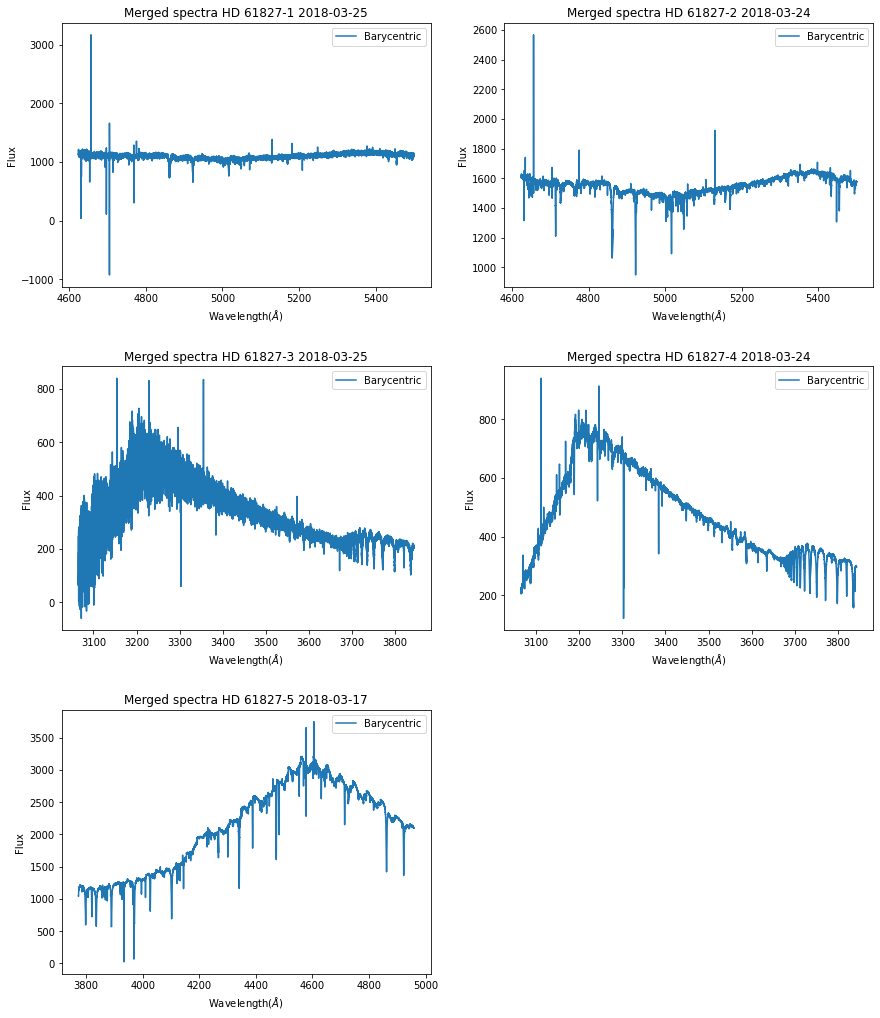

In [4]:
#extracting raw information from data files and plotting spectra

#structure of array of rdata array is as follows:-
#[array of info of first observation,
# array of info of second observation,
# array of info of third observation,.....]
#
#where structure of array of info of a observation is as ->
#[date of observation as a string, array of data of observation]
#
#where in the array of data of observation, first column is the wavelengths 
#and second column is the respective intensities

rdata = np.empty(shape=obs, dtype=object)
fig1,ax1 = plt.subplots(-(-obs//2),2,figsize=(12,-5*(-obs//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])


for z1,file in enumerate (filename):
    sp = EdiblesSpectrum(file)
    
    leftEdge = 0
    rightEdge = 0
    
    if min_range <= np.min(sp.raw_wave):
        leftEdge = 1
        #print('Left edge detected')
    if max_range >= np.max(sp.raw_wave):
        rightEdge = 1
        #print('Right edge detected')
        
        
    sp.getSpectrum(xmin = max(min_range, np.min(sp.raw_wave)+1)
                   , xmax = min(max_range, np.max(sp.raw_wave)-1))
    
    
    infoarr = np.empty(shape=2, dtype=object)
    
    infoarr[0] = str(sp.datetime.day)+'/'+str(sp.datetime.month)+'/'+str(sp.datetime.year)
    infoarr[1] = np.delete(np.array([sp.bary_wave, sp.bary_flux]).transpose(), 
                           np.logical_or(sp.bary_wave <= np.min(sp.bary_wave) + 40.0*leftEdge, 
                                         sp.bary_wave >= np.max(sp.bary_wave) - 40.0*rightEdge), 0)

    
    rdata[z1] = infoarr
    
    if(obs<3):
        fax1 = ax1[z1]
    else:
         fax1 = ax1[z1//2, z1%2]   
    
    fax1.plot(rdata[z1][1][:, 0], rdata[z1][1][:, 1], label='Barycentric')
    title1 = 'Merged spectra '+target+'-'+str(z1+1) +" "+ str(sp.datetime.date())
    fax1.set_title(title1)
    fax1.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
    fax1.legend()
    
if obs%2 != 0:
    fig1.delaxes(ax1[obs//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

In [8]:
print(len(rdata))
print(rdata.shape)
print(rdata[1])

7
(7,)
['24/4/2017' array([[4624.06997564, 2790.78662109],
                    [4624.08997681, 2800.72680664],
                    [4624.10997798, 2792.92602539],
                    ...,
                    [5499.92122881, 2375.17138672],
                    [5499.94122998, 2384.17407227],
                    [5499.96123115, 2369.89111328]])]


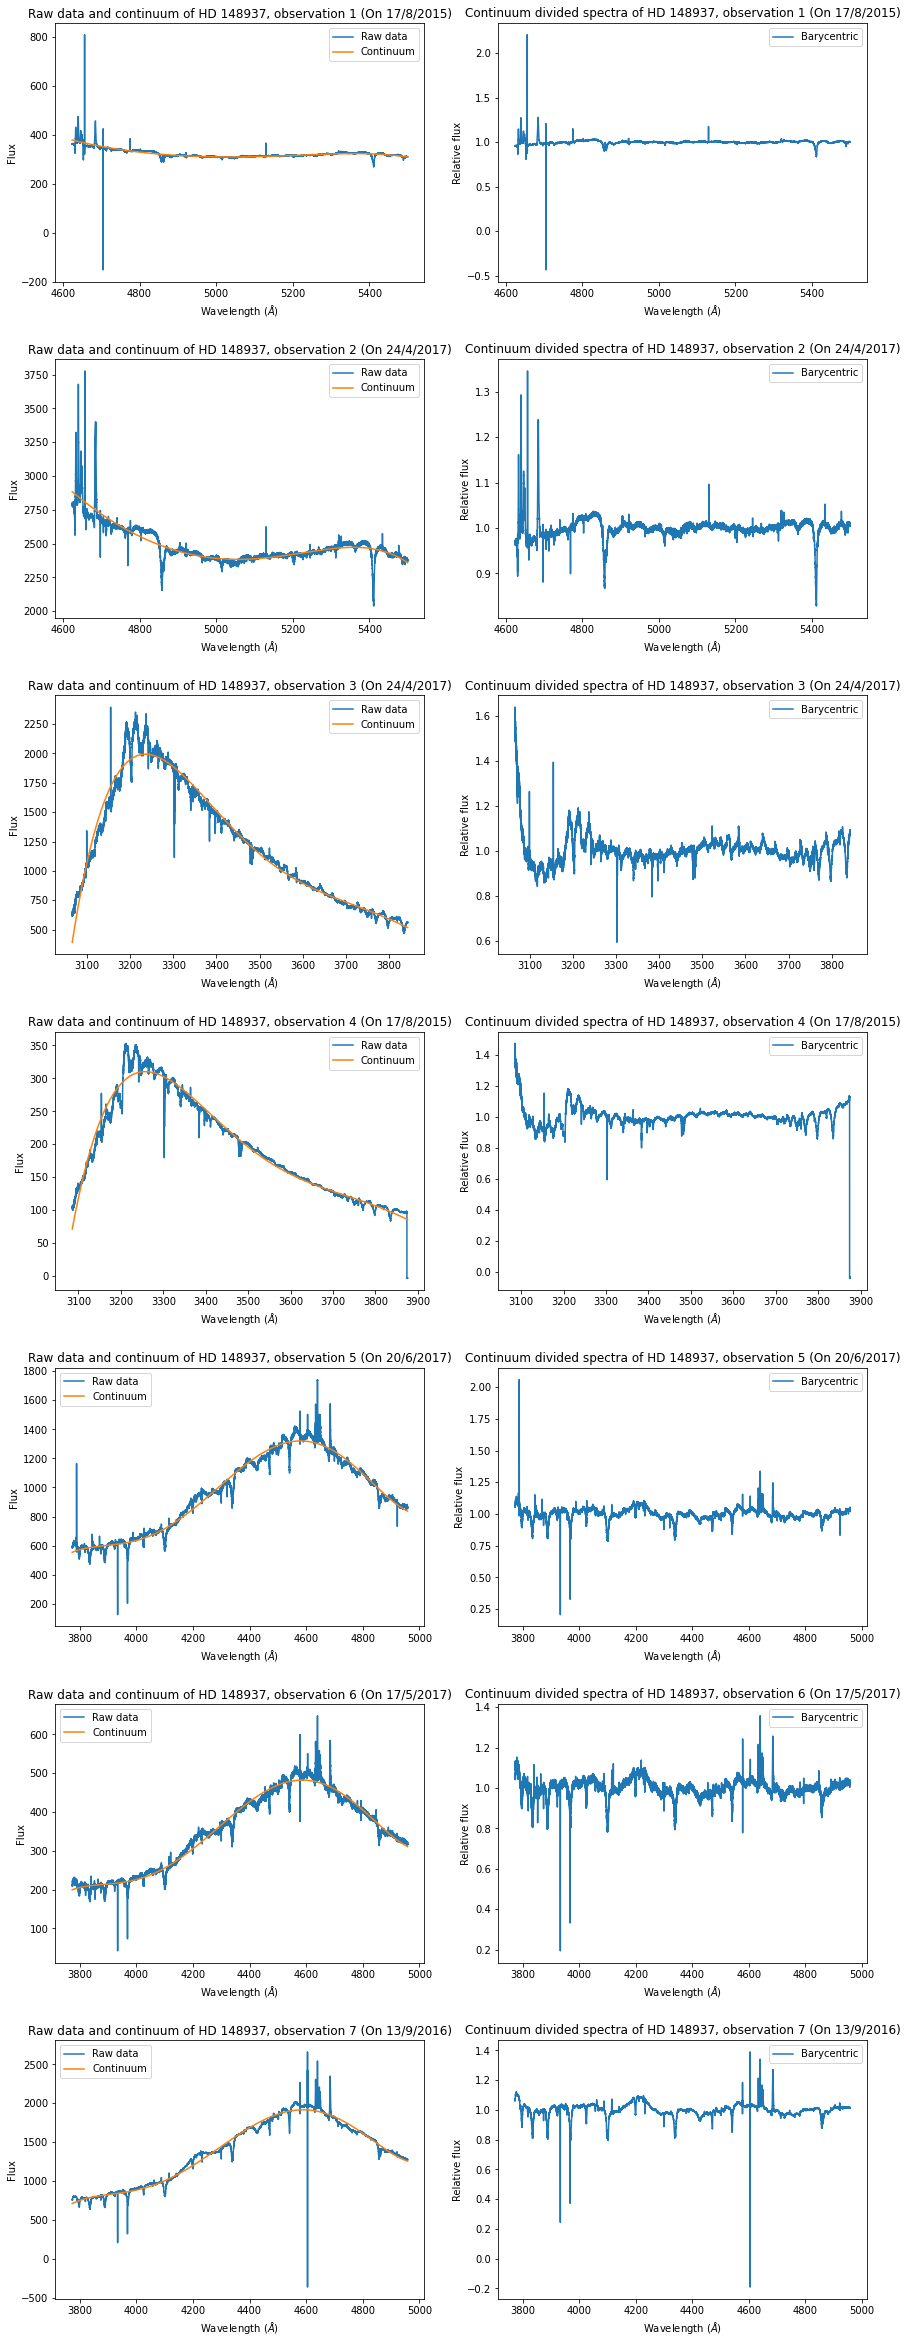

In [9]:
#removing the continuum from the spectrum

cont_rdata = copy.deepcopy(rdata)

fig2,ax2 = plt.subplots(obs, 2, figsize=(12,5*obs))
plt.tight_layout(rect=[0,0.03,1,0.95])

for z2 in range(obs):
    x1 = copy.deepcopy(rdata[z2][1][:, 0])
    y1 = copy.deepcopy(rdata[z2][1][:, 1])

    spectrum1 = Spectrum1D(flux = y1*u.dimensionless_unscaled, spectral_axis = x1*u.angstrom)

    with warnings.catch_warnings():  # Ignore warnings
        warnings.simplefilter('ignore')
        g1_fit = fit_generic_continuum(spectrum1, model = models.Legendre1D(degree = 5))
    
    cont_rdata[z2][1][:, 1] = y1/g1_fit(x1*u.angstrom)
    
    if(obs < 2):
        fax2i = ax2[0]
        fax2ii = ax2[1]
    else:
        fax2i = ax2[z2, 0]
        fax2ii = ax2[z2, 1]
    
    fax2i.plot(x1, y1, label = "Raw data")
    fax2i.plot(x1, g1_fit(x1*u.angstrom), label = "Continuum")
    tit2i = 'Raw data and continuum of ' + target + ', observation ' + str(z2+1) + ' (On ' + cont_rdata[z2][0] + ')'
    fax2i.set_title(tit2i)
    fax2i.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Flux')
    fax2i.legend()
    
    fax2ii.plot(x1, cont_rdata[z2][1][:, 1], label = 'Barycentric')
    tit2ii = 'Continuum divided spectra of ' + target + ', observation ' + str(z2+1) + ' (On ' + cont_rdata[z2][0] + ')'
    fax2ii.set_title(tit2ii)
    fax2ii.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Relative flux')
    fax2ii.legend()

#if obs%2 != 0:
    #fig2.delaxes(ax2[obs//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

In [10]:
def dataInRange(data1, rangeArr1):
    return data1[np.logical_and(data1[:, 0] >= rangeArr1[0], data1[:, 0] <= rangeArr1[1]), :]

In [11]:
#removing the emission lines from the spectrum
em_rdata = copy.deepcopy(cont_rdata)

fig5,ax5 = plt.subplots(-(-obs//2), 2, figsize=(12,-5*(-obs//2)))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for z5 in range(obs):
    cf3 = ContinuumFitter(cont_rdata[z5][1][:, 0], cont_rdata[z5][1][:, 1])
    cf33 = cf3.SelectPoints(n=100, y_message = 'Select emission peak start and end points', nearest = False, vetoTimeout = True)
    
    if(obs < 3):
        fax5 = ax5[z5]
    else:
        fax5 = ax5[z5//2, z5%2]
        
    if(cf33.shape[0] == 0):
        fax5.plot(em_rdata[z5][1][:, 0], em_rdata[z5][1][:, 1], label="Barycentric (No lines to remove)")
    
    else:
        wvs2 = cf33[:, 0]
        wvs2y = cf33[:, 1]
        peakRanges2 = np.reshape(wvs2, (int(wvs2.size/2), 2))
        peakRanges2y = np.reshape(wvs2y, (int(wvs2y.size/2), 2))
        for z55 in range(peakRanges2.shape[0]):
            dcir = dataInRange(cont_rdata[z5][1], peakRanges2[z55])
            base1 = np.linspace(peakRanges2y[z55, 0], peakRanges2y[z55, 1], num = dcir.shape[0])
            res2 = voigtUniPeak(peakData = dcir, plot = 0, base = base1, retMod = True)
            em_rdata[z5][1][np.logical_and(em_rdata[z5][1][:, 0] >= peakRanges2[z55, 0], em_rdata[z5][1][:, 0] <= peakRanges2[z55, 1]), 1] = dcir[:, 1]/(base1 - res2.best_fit)
        
        fax5.plot(cont_rdata[z5][1][:, 0], cont_rdata[z5][1][:, 1], label="Barycentric (Emission lines not removed)")
        fax5.plot(em_rdata[z5][1][:, 0], em_rdata[z5][1][:, 1], label="Barycentric (Emission lines removed)")
    
    

    title5 = 'Spectra of ' + target + ', observation ' + str(z5+1) + ' (On ' + em_rdata[z5][0] + ')'
    fax5.set_title(title5)
    fax5.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Flux')
    fax5.legend()

if obs%2 != 0:
    fig5.delaxes(ax5[len(em_rdata)//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

<Figure size 432x288 with 0 Axes>

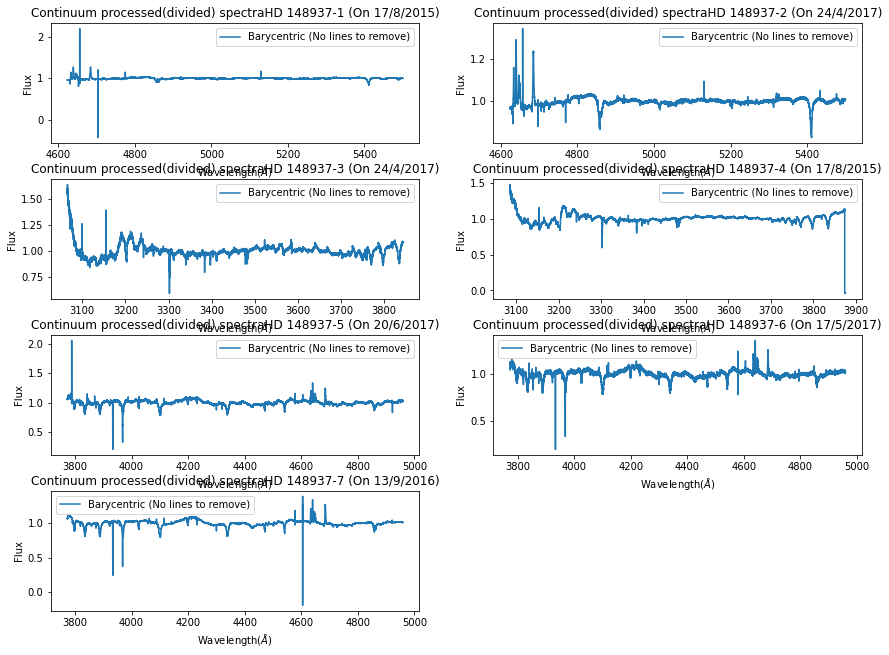

In [12]:
#removing the stellar lines from the spectrum

line_rdata = copy.deepcopy(em_rdata)
#sd = 8.770

fig3,ax3 = plt.subplots(-(-obs//2), 2, figsize=(12,-5*(-obs//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])

for z3 in range(obs):
    cf2 = ContinuumFitter(em_rdata[z3][1][:,0], em_rdata[z3][1][:,1])
    cf22 = cf2.SelectPoints(n=100, y_message = 'Select absorption peak start and end points', nearest = False, vetoTimeout = True)
    
    if(obs<3):
        fax3 = ax3[z3]
    else:
        fax3 = ax3[z3//2, z3%2]  
    
    if(cf22.shape[0] == 0):
        fax3.plot(line_rdata[z3][1][:, 0], line_rdata[z3][1][:, 1], label="Barycentric (No lines to remove)")
    else:
        wvs1 = cf22[:, 0]
        wvs1y = cf22[:, 1]
        peakRanges = np.reshape(wvs1, (int(wvs1.size/2), 2))
        peakRangesy = np.reshape(wvs1y, (int(wvs1y.size/2), 2))
        for z33 in range(peakRanges.shape[0]):
            dcir1 = dataInRange(em_rdata[z3][1], peakRanges[z33])
            base2 = np.linspace(peakRangesy[z33, 0], peakRangesy[z33, 1], num = dcir1.shape[0])
            res1 = voigtUniPeak(peakData = dcir1, plot = 0, base = base2, retMod = True)
            line_rdata[z3][1][np.logical_and(line_rdata[z3][1][:, 0] >= peakRanges[z33, 0], line_rdata[z3][1][:, 0] <= peakRanges[z33, 1]), 1] = dcir1[:, 1]/(base2 - res1.best_fit)
        
            
        fax3.plot(em_rdata[z3][1][:, 0], em_rdata[z3][1][:, 1], label="Barycentric (Absorption lines not removed)")
        fax3.plot(line_rdata[z3][1][:, 0], line_rdata[z3][1][:, 1], label="Barycentric (Absorption lines removed)")
    
    
    title3 = 'Continuum processed(divided) spectra'+target+'-'+str(z3+1)+' (On ' + line_rdata[z3][0] + ')'
    fax3.set_title(title3)
    fax3.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
    fax3.legend()
    
if obs%2 != 0:
    fig3.delaxes(ax3[len(line_rdata)//2,1])
plt.subplots_adjust(hspace=0.3, wspace=0.2)

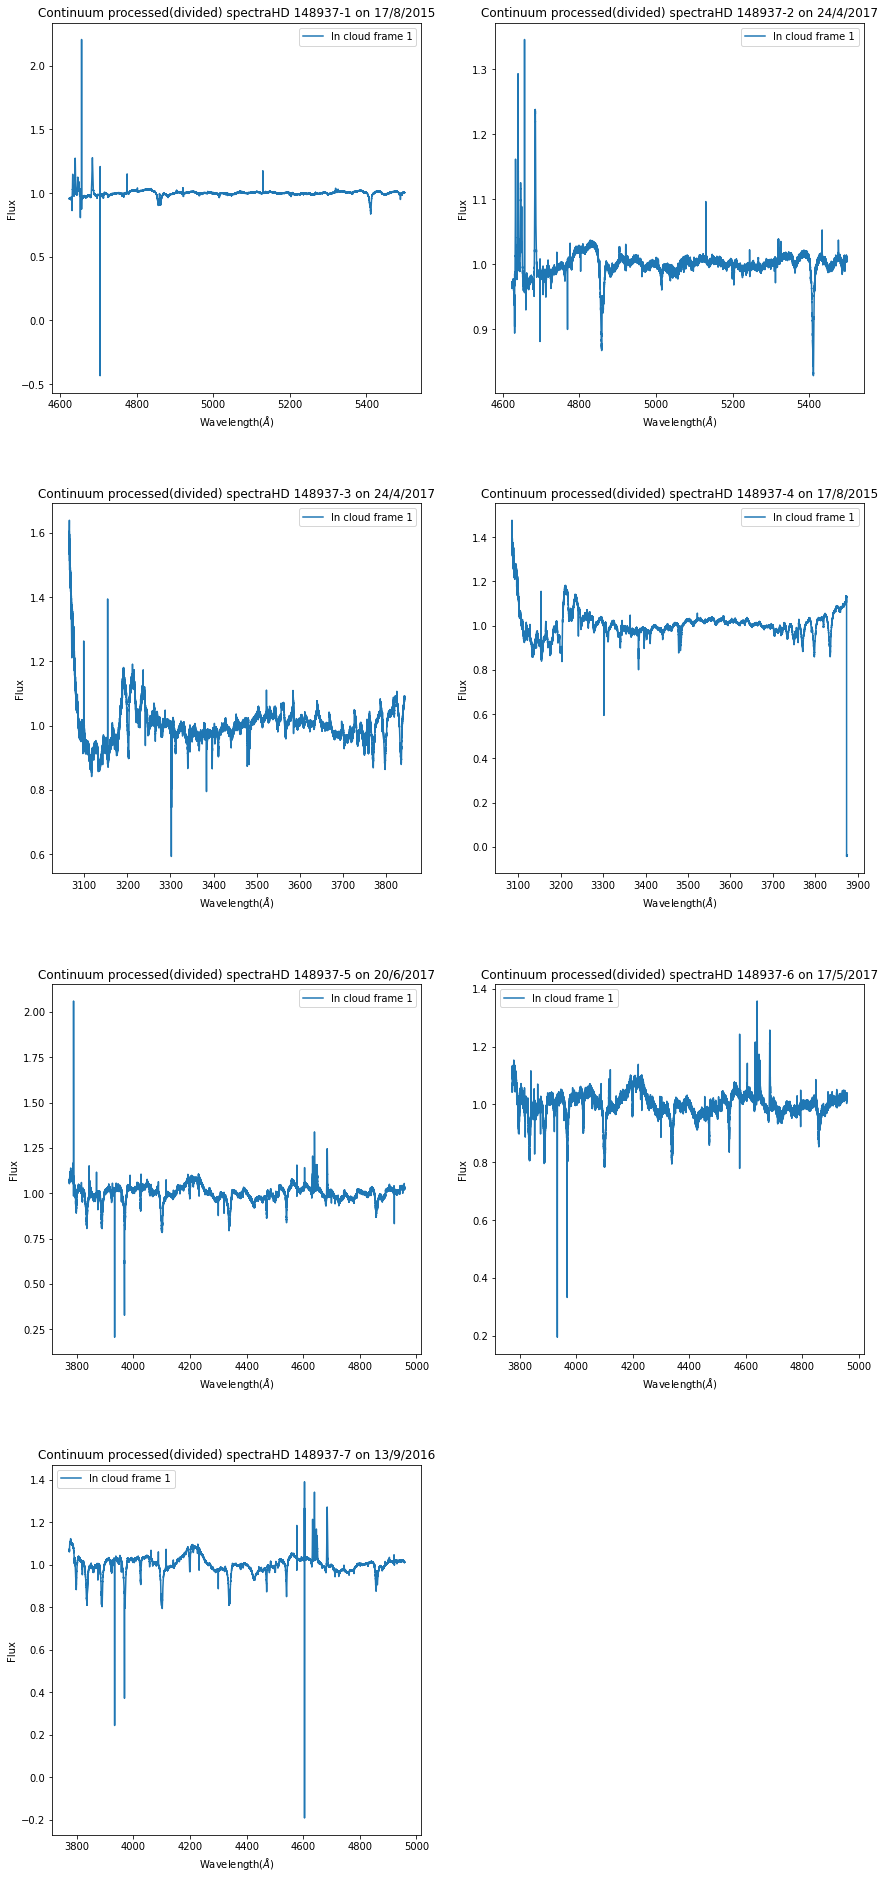

In [13]:
#shifting the spectrum to the clouds' frame

with open('/home/devotosh01/Western_work/Work/Pentacene/rad_vel_edibles.txt') as f:
    for l in f:
        l = l.replace('\n', '')
        l = l.split(',')
        
        if (l[0])==target.replace(' ',''):
            vel = l[1].split(';')
            break

clouds = len(vel)
datas = np.empty(shape=clouds, dtype = object)
for z4 in range(clouds):
    datas[z4] = copy.deepcopy(line_rdata)
    
fig4,ax4 = plt.subplots(-((-obs*clouds)//2),2,figsize=(12,-7*((-obs*clouds)//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])

for v2 in range(clouds):
    for v1 in range(obs):
        datas[v2][v1][1][:,0] = datas[v2][v1][1][:,0] * (1+(float(vel[v2])/299792.458))
        
        if(obs*clouds<3):
            fax4 = ax4[v2*obs+v1]
        else:
            fax4 = ax4[(v2*obs + v1)//2, (v2*obs + v1)%2]   
    
        lb = 'In cloud frame '+ str(v2+1)
        fax4.plot(datas[v2][v1][1][:,0], datas[v2][v1][1][:,1], label=lb)        
        title4 = 'Continuum processed(divided) spectra'+target+'-'+str(v1+1) +" on "+ datas[v2][v1][0]
        fax4.set_title(title4)
        fax4.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
        fax4.legend()
    
if (obs*clouds)%2 != 0:
    fig4.delaxes(ax4[obs*clouds//2,1])
plt.subplots_adjust(hspace=0.3, wspace=0.2)

In [14]:
def widthNormLinStacker(fdata2, peakParam2):
    
    P2 = peakParam2.shape[0]
    
    
    #plotting spectrum
    
    ffig2, faxs2 = plt.subplots(3, 2, figsize=(12,15))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    faxs2[0, 0].plot(fdata2[:, 0], fdata2[:, 1], label = 'Spectrum')
    
    faxs2[0, 0].set_title('Full spectrum')
    faxs2[0, 0].set(xlabel = 'Wavelength in Å', ylabel = 'Relative intensity')
    faxs2[0, 0].legend()
    
    
    #extracting peaks
    
    fpdshifted2 = np.empty(shape = P2, dtype = object)
    skipper1 = 0
    nonSkip = np.array([])
    
    for i2 in range(P2):
        #extracting wavelengths and intensities within ranges given by peakParam2
        #total width of peak is being taken to be 4*FWHM
        tbc1 = fdata2[np.logical_and(fdata2[:, 0]>=peakParam2[i2, 0]-2*peakParam2[i2, 1]
                                     , fdata2[:, 0]<=peakParam2[i2, 0]+2*peakParam2[i2, 1]), :]
        
        #if it does not find 90% of the wavelengths in a peak's range, it skips that peak
        if tbc1.shape[0] == 0 or (np.min(tbc1[:, 0]) >= peakParam2[i2, 0] - 0.90*2*peakParam2[i2, 1]) or (np.max(tbc1[:, 0]) <= peakParam2[i2, 0] + 0.90*2*peakParam2[i2, 1]):
            #print('Range ' + str(peakParam2[i2, 0]) + ' to ' + str())
            skipper1 = skipper1 + 1
        else:
            nonSkip = np.append(nonSkip, i2)
            pkLbl2 = 'Just peak ' + str(i2+1)
            faxs2[0, 1].plot(tbc1[:, 0], tbc1[:, 1], label = pkLbl2)
            
            #shifting the above peaks by central value and dividing by FWHM/2
            tbc2 = tbc1
            tbc2[:, 0] = (tbc1[:, 0] - peakParam2[i2, 0])/(peakParam2[i2, 1]/2)
            fpdshifted2[i2 - skipper1] = tbc2
            shPkLbl2 = 'Shifted peak ' + str(i2+1)
            faxs2[1, 0].plot(fpdshifted2[i2 - skipper1][:, 0], fpdshifted2[i2 - skipper1][:, 1], label = shPkLbl2)
    
    if skipper1 == P2:
        ffig2.clf()
        print('No peaks in range')
        return np.array([])
    else:
        faxs2[0, 1].set_title('Spectrum with just peaks')
        faxs2[0, 1].set(xlabel = 'Wavelength in Å', ylabel = 'Relative intensity')
        #faxs2[0, 1].legend()
        
        faxs2[1, 0].set_title('Spectrum with peaks shifted')
        faxs2[1, 0].set(xlabel = 'Shifted and normalised wavelength', ylabel = 'Relative intensity')
        #faxs2[1, 0].legend()
        
        fpdshifted2 = fpdshifted2[ : P2 - skipper1]
        #print(skipper1)
        #print(fpdshifted2.shape)
        
        #calculating no of points, wavelength ranges and corresponding equally distributed wavelengths
        
        fnosPoints2 = fpdshifted2[0].shape[0]
        #minWave2 = peakParam2[0][0]-peakParam2[0][1]
        #maxWave2 = peakParam2[0][2]-peakParam2[0][1]
        minWave2 = np.min(fpdshifted2[0][:, 0])
        maxWave2 = np.max(fpdshifted2[0][:, 0])
        
        for k2 in range(fpdshifted2.shape[0]):
            #print('Peak ' + str(nonSkip[k2]) + ' - ' + str(np.min(fpdshifted2[k2][:, 0])) + ' to ' + str(np.max(fpdshifted2[k2][:, 0])))
            if fpdshifted2[k2].shape[0] > fnosPoints2:
                fnosPoints2 = fpdshifted2[k2].shape[0]
            if np.min(fpdshifted2[k2][:, 0]) > minWave2:
                minWave2 = np.min(fpdshifted2[k2][:, 0])
            if np.max(fpdshifted2[k2][:, 0]) < maxWave2:
                maxWave2 = np.max(fpdshifted2[k2][:, 0])
        fwavelengths2 = np.linspace(minWave2, maxWave2, num = fnosPoints2)
    
    
        #interpolation
    
        ffa2 = np.empty(shape = fpdshifted2.shape[0], dtype = object)
    
        for l2 in range(fpdshifted2.shape[0]):
            ffa2[l2] = interp1d(fpdshifted2[l2][:, 0], fpdshifted2[l2][:, 1])
    
    
        #plotting interpolated peaks and stacked peak
    
        ffinalData2 = np.zeros((fnosPoints2, 2))
        ffinalData2[:, 0] = fwavelengths2
        
        for m2 in range(fpdshifted2.shape[0]):
            tmpHol2 = ffa2[m2](fwavelengths2)
            ffinalData2[:, 1] = ffinalData2[:, 1] + (tmpHol2/float(fpdshifted2.shape[0]))
            lab2 = 'Interpolated peak ' + str(nonSkip[m2]+1)
            faxs2[1, 1].plot(fwavelengths2, tmpHol2, label = lab2)
    
        #print(ffinalData2.shape)
    
        faxs2[1, 1].plot(ffinalData2[:, 0], ffinalData2[:, 1], label = 'Stacked peak')
        
        faxs2[1, 1].set_title('Spectrum with peaks interpolated in calculated range and stacked peak')
        faxs2[1, 1].set(xlabel = 'Shifted and normalised wavelength', ylabel = 'Relative intensity')
        #faxs2[1, 1].legend()
            
        faxs2[2, 0].plot(ffinalData2[:, 0], ffinalData2[:, 1], label = 'Just stacked peak')
        
        faxs2[2, 0].set_title('Just stacked peak')
        faxs2[2, 0].set(xlabel = 'Shifted and normalised wavelength', ylabel = 'Relative intensity')
        faxs2[2, 0].legend()
        
        ffig2.delaxes(faxs2[2, 1])
        
        plt.subplots_adjust(hspace=0.3, wspace=0.2)
        fullTitle2 = 'Plots for stacking'
        plt.suptitle(fullTitle2, size = 18)
    
        #print(ffinalData2.shape)
        return ffinalData2

In [17]:
def observationStacker(obsDataRaw, axsInfo, saveJPG = False, address = ''):
    assert (not saveJPG) or address != '', 'Enter some valid address'
    
    P2 = len(obsDataRaw)
    
    
    #removing empty observations
    
    obsData = np.empty(shape = P2, dtype = object)
    
    skipper2 = 0
    
    for i2 in range(P2):
        if obsDataRaw[i2].shape[0] == 0:
            skipper2 = skipper2 + 1
        else:
            obsData[i2 - skipper2] = obsDataRaw[i2]
    
    obsData = obsData[ : P2 - skipper2]
    
    
    #plotting all observations
    
    ffig2, faxs2 = plt.subplots(1, 2, figsize=(12,5))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    for i1 in range(len(obsData)):
        obsLab1 = 'Observation ' + str(i1+1)
        faxs2[0].plot(obsData[i1][:, 0], obsData[i1][:, 1], label = obsLab1)
    
    faxs2[0].set_title('All observations')
    
    if axsInfo[0][1] == 'No units':
        xlab1 = axsInfo[0][0]
    else:
        xlab1 = axsInfo[0][0] + ' in ' + axsInfo[0][1]
    
    if axsInfo[1][1] == 'No units':
        ylab1 = axsInfo[1][0]
    else:
        ylab1 = axsInfo[1][0] + ' in ' + axsInfo[1][1]
    
    faxs2[0].set(xlabel = xlab1, ylabel = ylab1)
    faxs2[0].legend()
    
    
    #calculating no of points, wavelength ranges and corresponding equally distributed wavelengths
    
    fnosPoints2 = obsData[0].shape[0]
    #minWave2 = peakParam2[0][0]-peakParam2[0][1]
    #maxWave2 = peakParam2[0][2]-peakParam2[0][1]
    minWave2 = np.min(obsData[0][:, 0])
    maxWave2 = np.max(obsData[0][:, 0])
    
    for k2 in range(len(obsData)):
        #print('Peak ' + str(nonSkip[k2]) + ' - ' + str(np.min(fpdshifted2[k2][:, 0])) + ' to ' + str(np.max(fpdshifted2[k2][:, 0])))
        if obsData[k2].shape[0] > fnosPoints2:
            fnosPoints2 = obsData[k2].shape[0]
        if np.min(obsData[k2][:, 0]) > minWave2:
            minWave2 = np.min(obsData[k2][:, 0])
        if np.max(obsData[k2][:, 0]) < maxWave2:
            maxWave2 = np.max(obsData[k2][:, 0])
    fwavelengths2 = np.linspace(minWave2, maxWave2, num = fnosPoints2)
    
    
    #interpolation
    
    ffa2 = np.empty(shape = P2, dtype = object)
    
    for l2 in range(len(obsData)):
        ffa2[l2] = interp1d(obsData[l2][:, 0], obsData[l2][:, 1])
    
    
    #plotting interpolated peaks and stacked peak
    
    ffinalData2 = np.zeros((fnosPoints2, 2))
    ffinalData2[:, 0] = fwavelengths2
    
    for m2 in range(len(obsData)):
        tmpHol2 = ffa2[m2](fwavelengths2)
        ffinalData2[:, 1] = ffinalData2[:, 1] + (tmpHol2/len(obsData))
    
    
    faxs2[1].plot(ffinalData2[:, 0], ffinalData2[:, 1], label = 'Just stacked peak')
    
    faxs2[1].set_title('Just stacked peak')
    faxs2[1].set(xlabel = xlab1, ylabel = ylab1)
    faxs2[1].legend()
    
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    fullTitle2 = 'Plots for stacking'
    plt.suptitle(fullTitle2, size = 18)
    
    if saveJPG:
        plt.savefig(address)
    
    #print(ffinalData2.shape)
    return ffinalData2

No peaks in range
No peaks in range
No peaks in range
No peaks in range


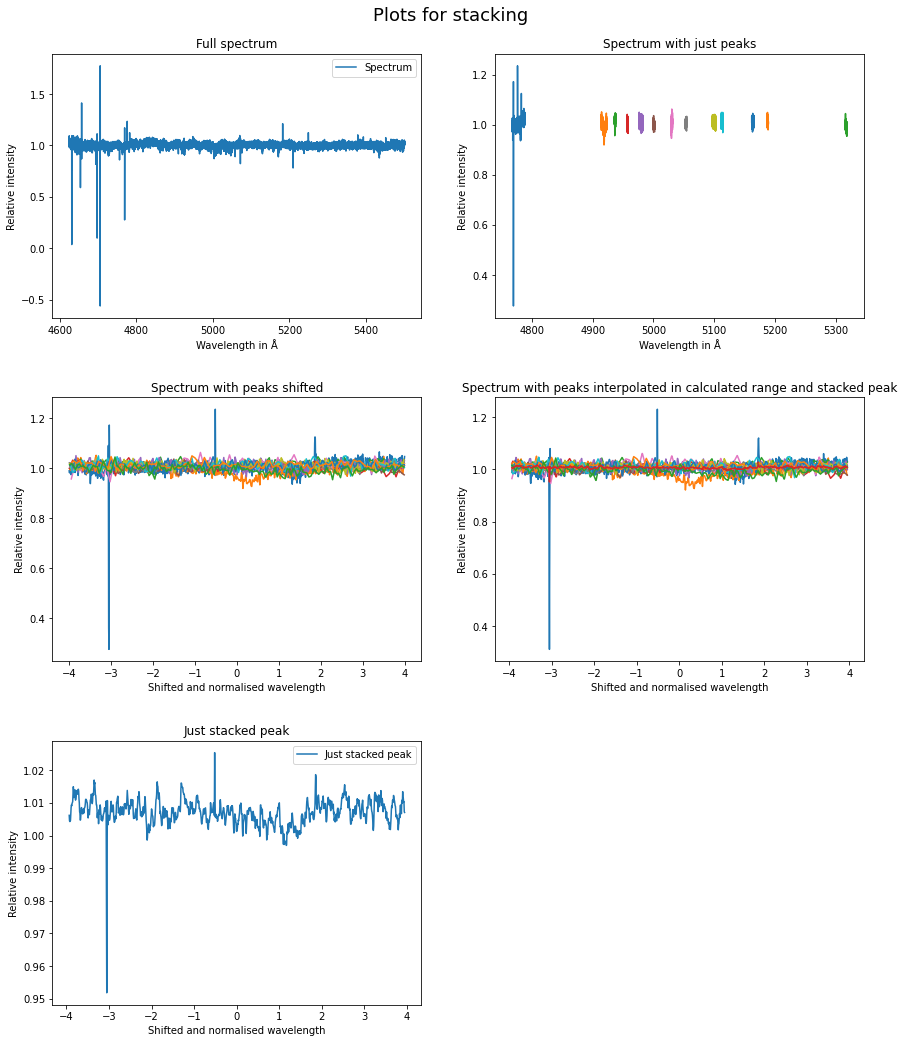

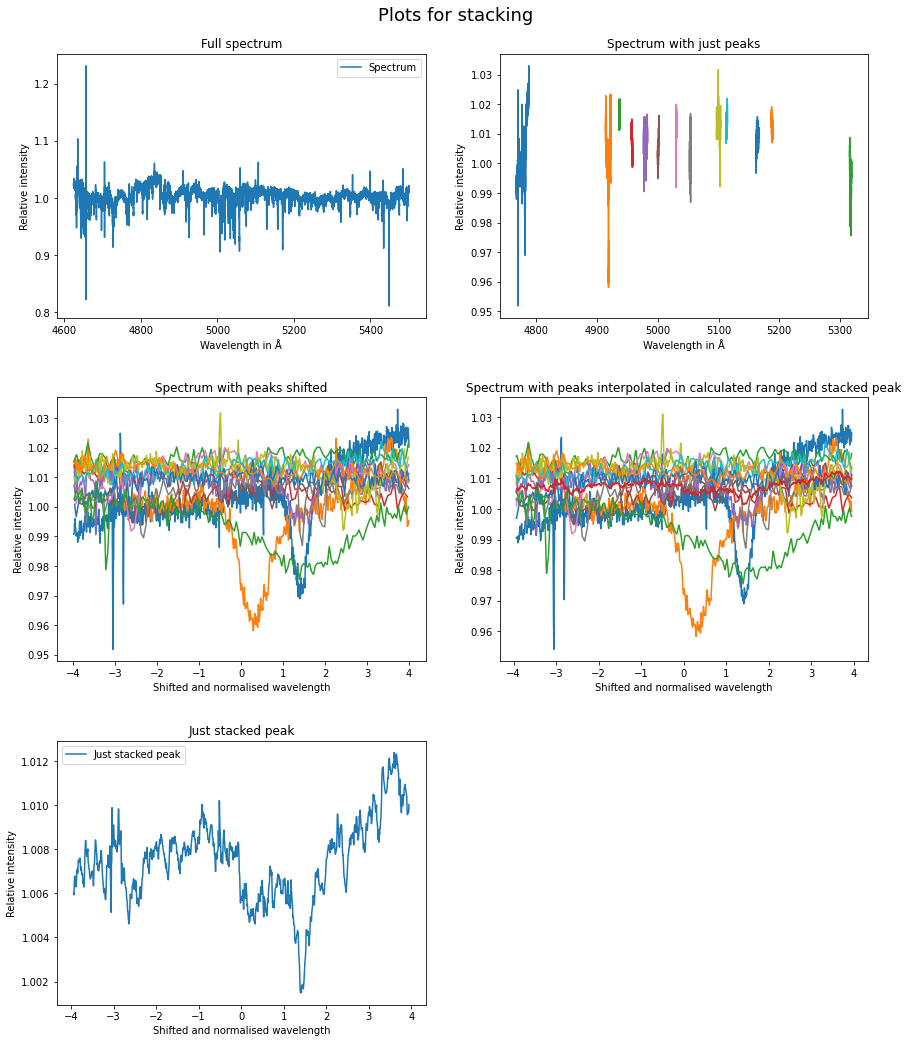

<Figure size 864x1080 with 0 Axes>

<Figure size 864x1080 with 0 Axes>

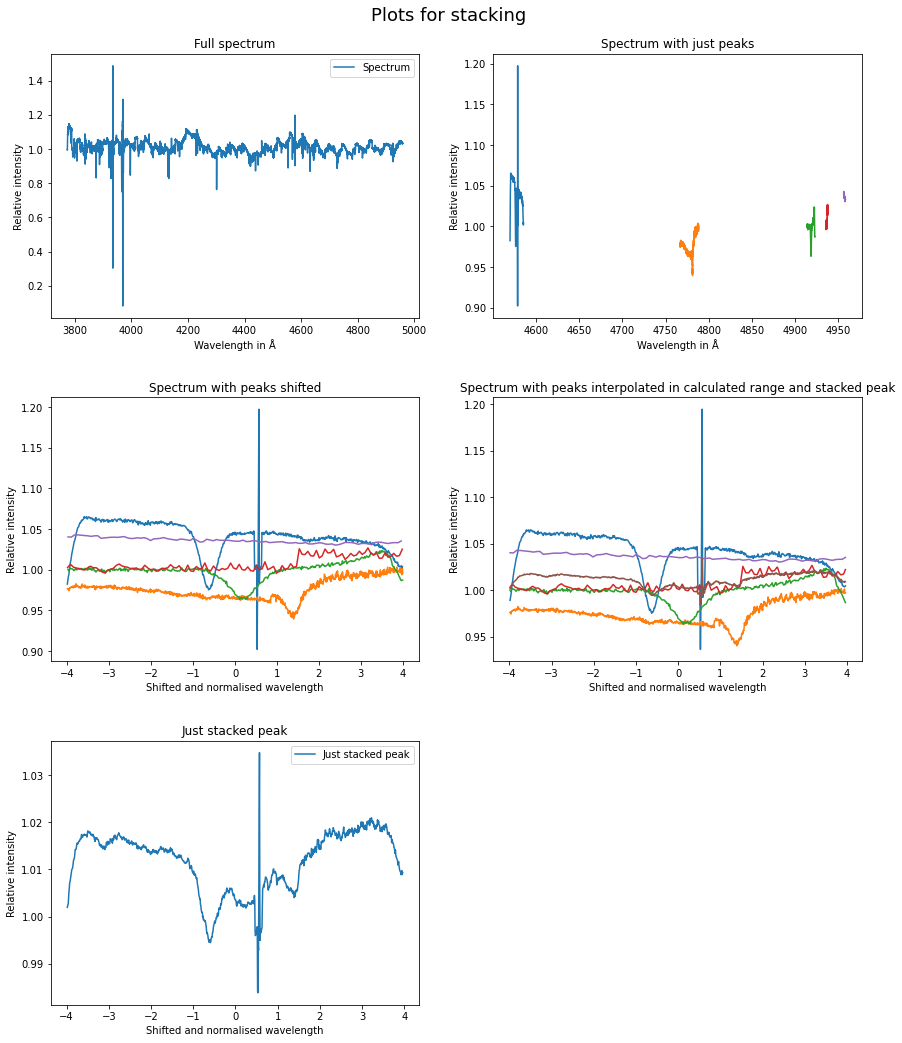

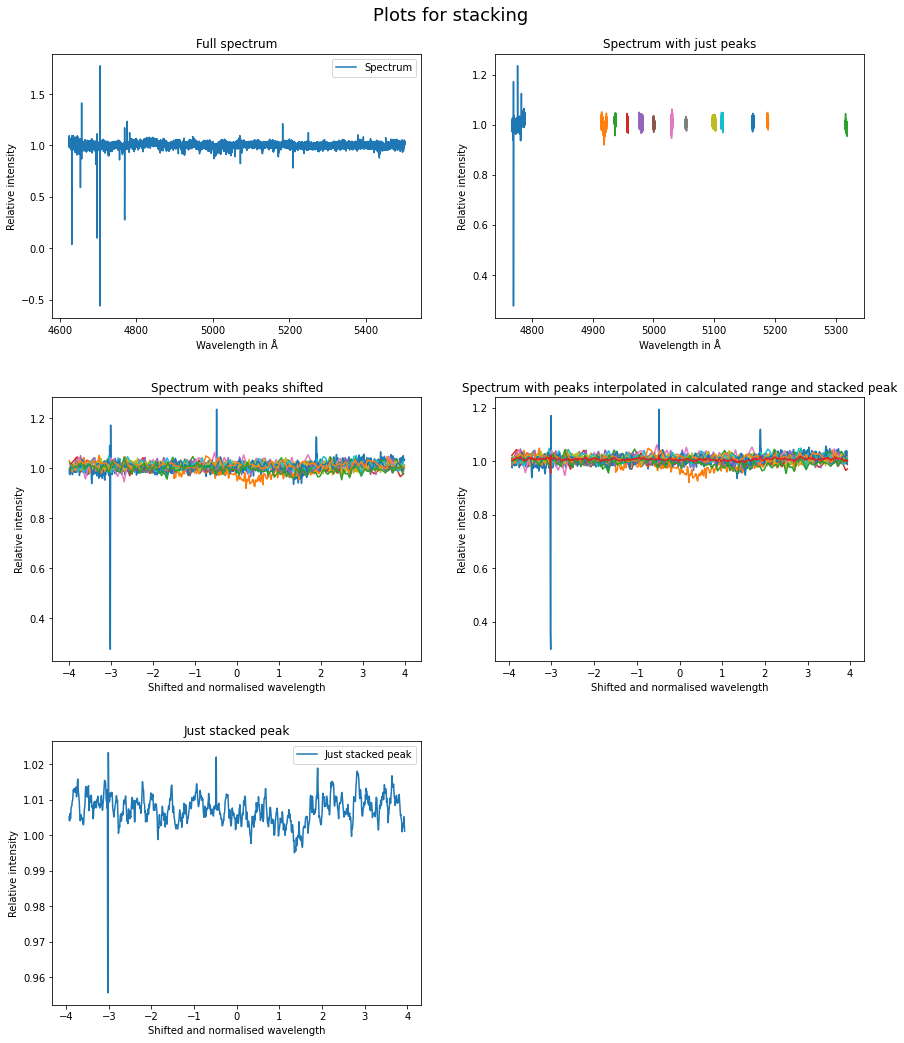

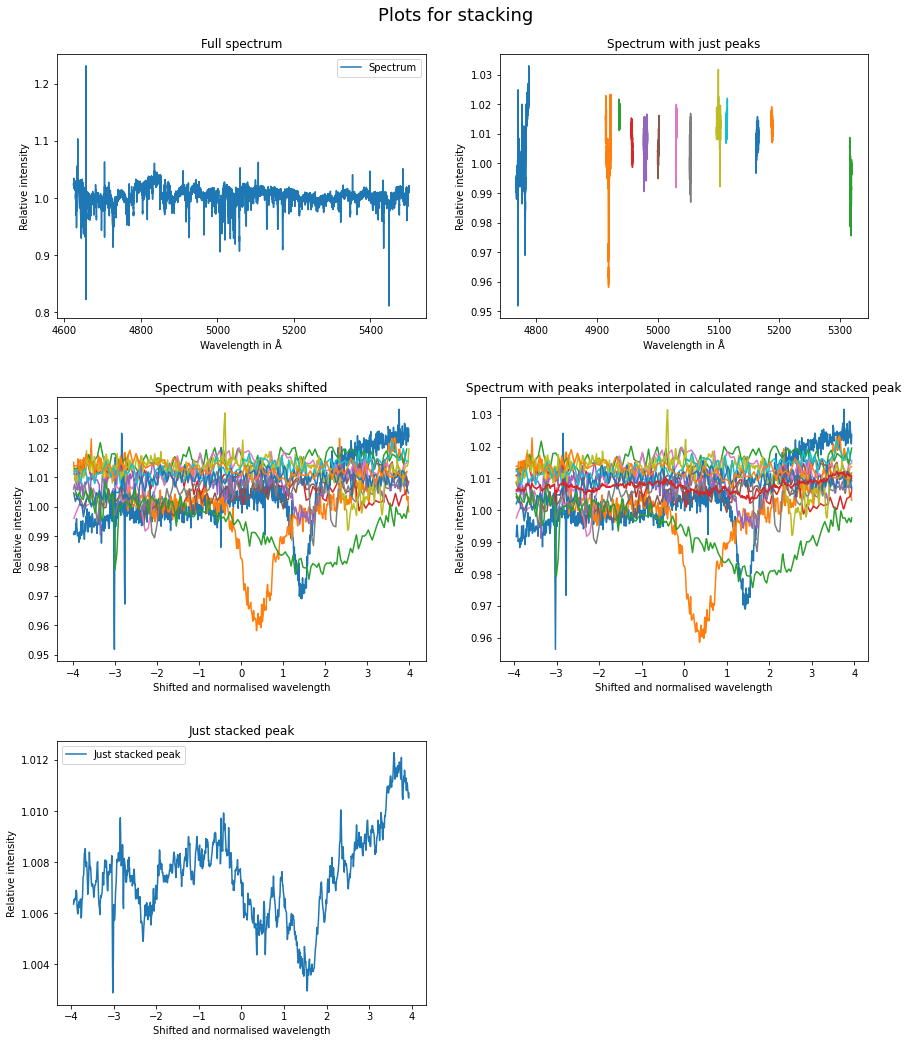

<Figure size 864x1080 with 0 Axes>

<Figure size 864x1080 with 0 Axes>

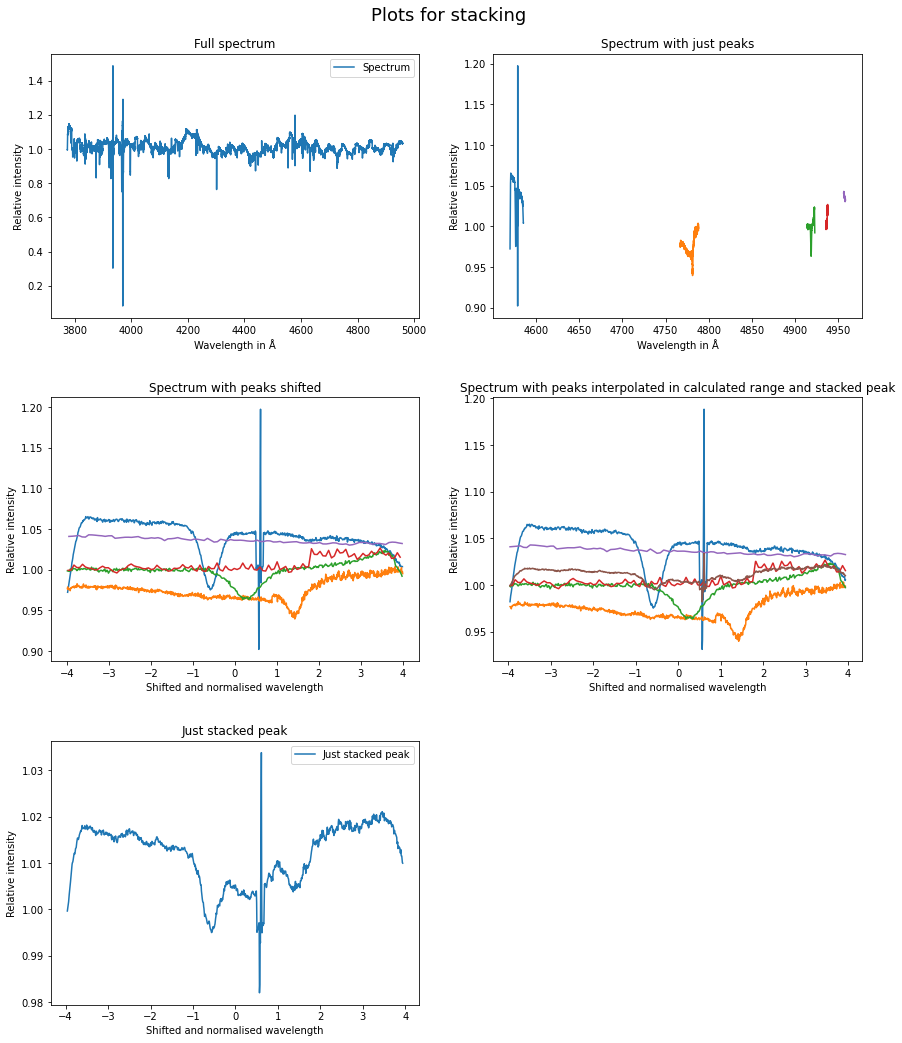

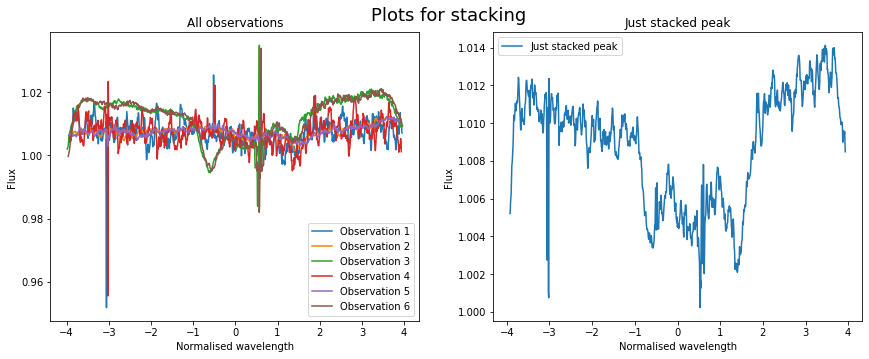

In [18]:
totalStack = np.empty(shape = clouds*obs, dtype = object)
#print(totalStack.shape)

for it8 in range(clouds):
    for it9 in range(obs):
        totalStack[it8 * len(datas[it8]) + it9] = widthNormLinStacker(datas[it8][it9][1], stack_par)
        clupFile = r'/home/devotosh01/Western_work/Work/Pentacene/STACKING_RESULTS/CleanedSpectra/' + target + '/' + target.replace(' ','') + '_Observation' + str(it8*obs + it9 + 1) + '_' + datas[it8][it9][0].replace('/','_') +'.txt'
        if (not os.path.exists(clupFile)) or fEdit1 == 1:
            np.savetxt(clupFile, datas[it8][it9][1])
 

       
#print(len(totalStack))
#print(stackRanges)
fileName = r'/home/devotosh01/Western_work/Work/Pentacene/STACKING_RESULTS/MolStacks/' + target + '/' + target.replace(' ','') + '_' + mol + '.txt'
imgFileName = r'/home/devotosh01/Western_work/Work/Pentacene/STACKING_RESULTS/MolStacks/' + target + '/' + target.replace(' ','') + '_' + mol + '.jpg'

if (not os.path.exists(fileName)) or fEdit2 == 1:
    imgSav = True
    imgAdd = imgFileName
else:
    imgSav = False
    imgAdd = ''

finalStacked = observationStacker(totalStack, 
                                  [['Normalised wavelength', 'No units'], ['Flux', 'No units']],
                                  saveJPG = imgSav,
                                  address = imgAdd)

if (not os.path.exists(fileName)) or fEdit2 == 1:
    np.savetxt(fileName, finalStacked)

In [2]:
print(PYTHONDIR)

/home/devotosh01/Western_work/Work/Pentacene/edibles/edibles


In [14]:
acenap = np.loadtxt("PENTACENE.DAT", skiprows=1).transpose()
acenap[0] = (1/acenap[0])*(10**7) 
data=acenap
datamol = data
datamol[0,:]=vac2air_ciddor(10.0*data[0,:])

cf1 = ContinuumFitter(datamol[0,:], datamol[1,:])
cf11, pts = cf1.SplineManualAnchor()

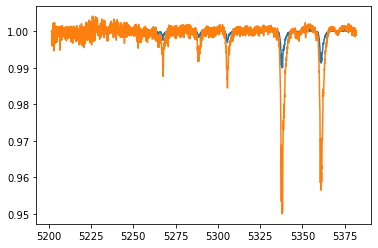

In [15]:
datamol[1,:]=1-0.01*(data[1,:]-(cf11(datamol[0,:])))/(np.max(data[1,:])-cf11(datamol[0, data[1,:] == np.max(data[1,:])]))
f_datamol = copy.deepcopy(datamol)
f_datamol[1,:] = f_datamol[1,:]-1
f_datamol[1,:] = 5*f_datamol[1,:]
f_datamol[1,:] = f_datamol[1,:]+1

plt.plot(datamol[0,:], datamol[1,:])
plt.plot(f_datamol[0,:], f_datamol[1,:])

<IPython.core.display.Javascript object>


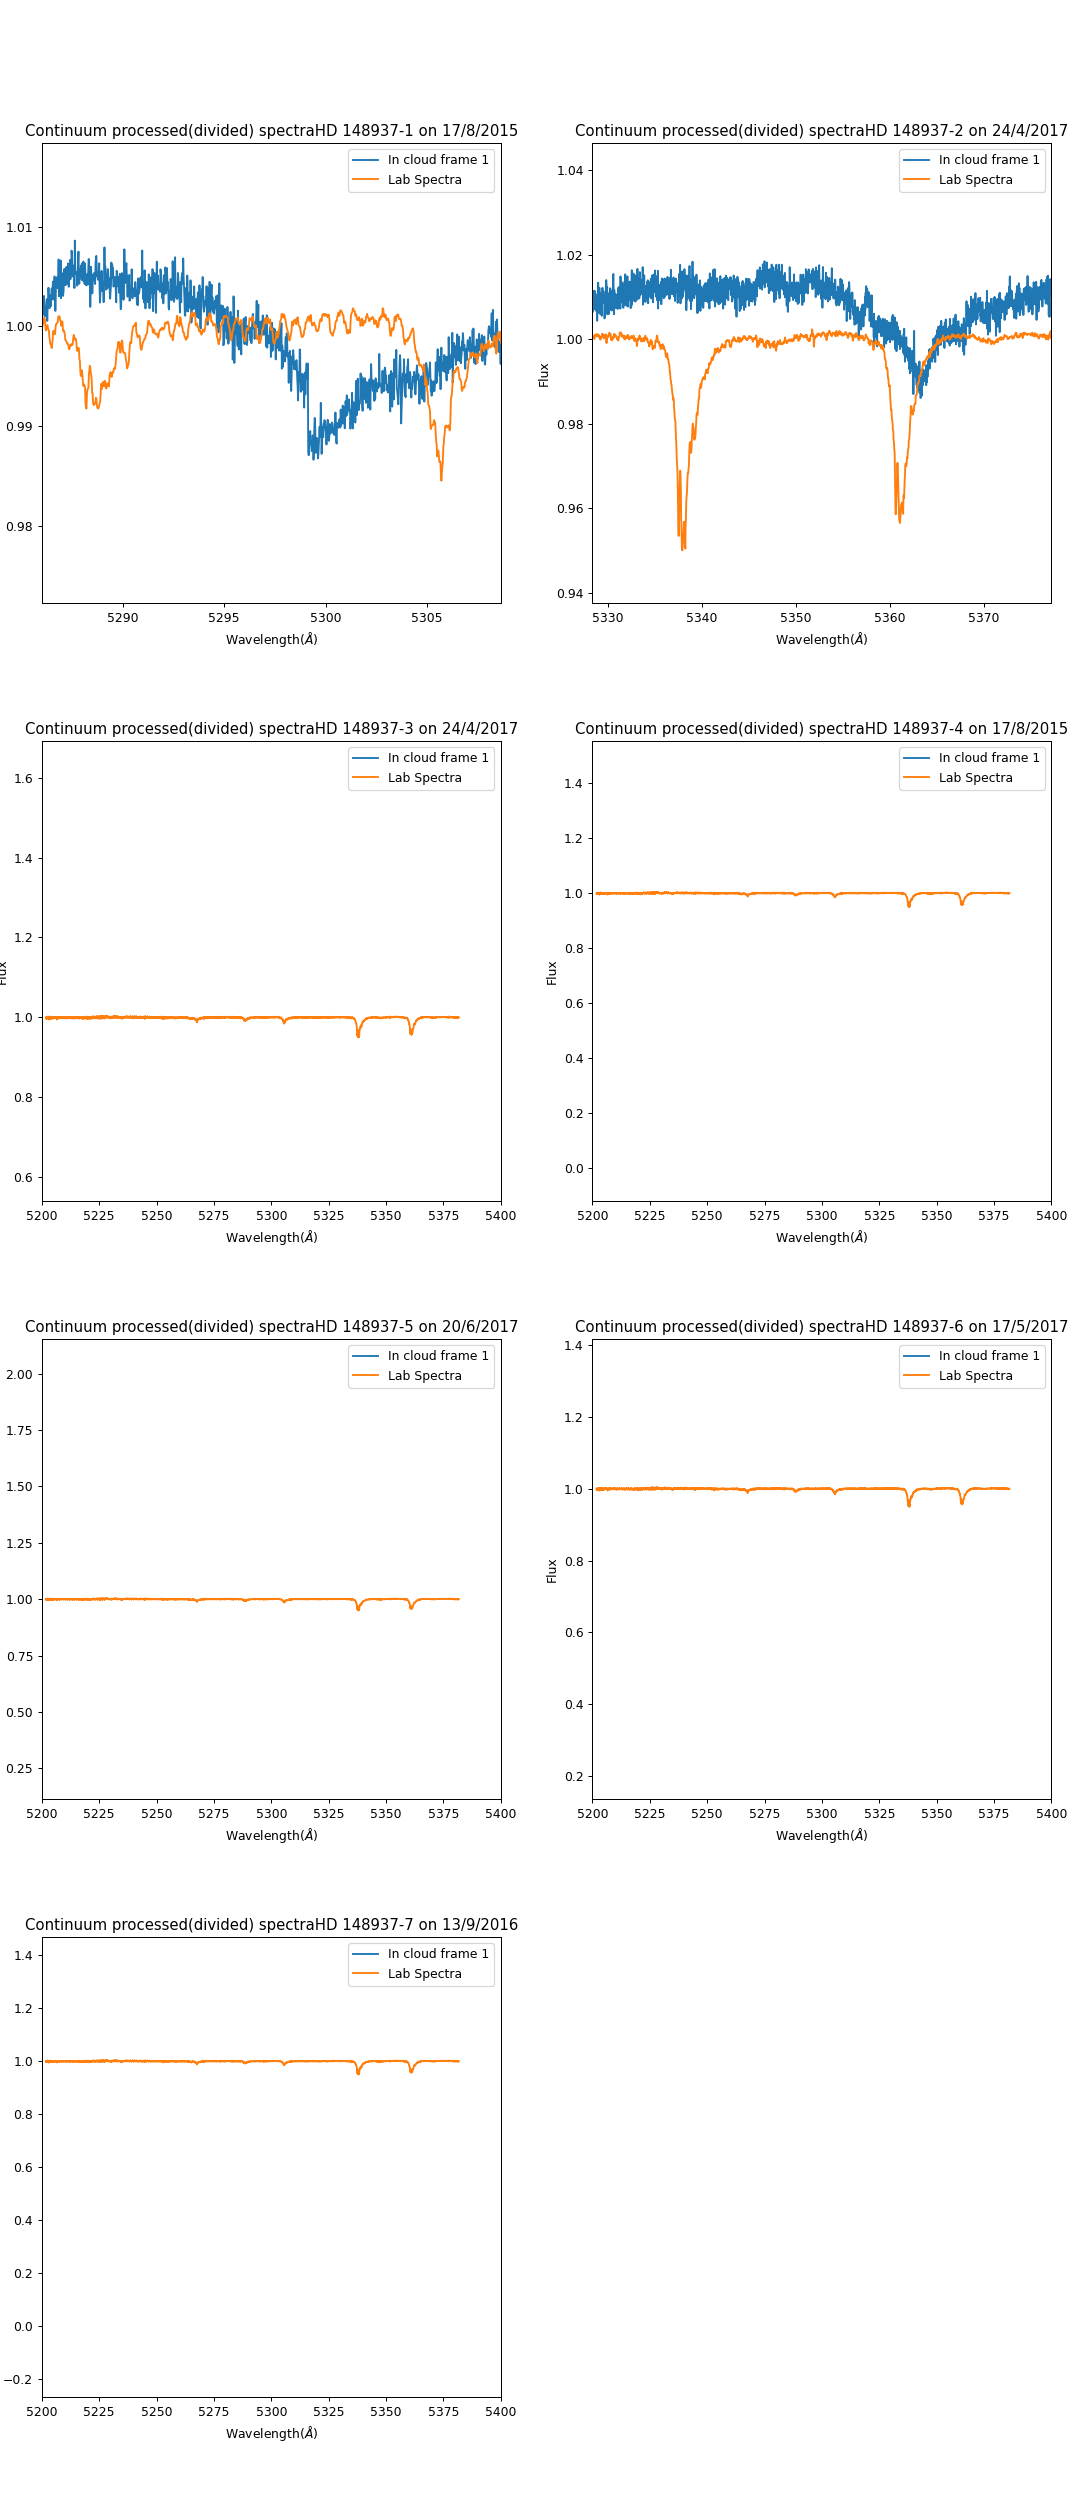

In [16]:
#shifting the spectrum to the clouds' frame
%matplotlib notebook
with open('/home/devotosh01/Western_work/Work/Pentacene/rad_vel_edibles.txt') as f:
    for l in f:
        l = l.replace('\n', '')
        l = l.split(',')
        
        if (l[0])==target.replace(' ',''):
            vel = l[1].split(';')
            break

clouds = len(vel)
datas = np.empty(shape=clouds, dtype = object)
for z4 in range(clouds):
    datas[z4] = copy.deepcopy(line_rdata)

fig6,ax6 = plt.subplots(-((-obs*clouds)//2),2,figsize=(12,-7*((-obs*clouds)//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])

for v2 in range(clouds):
    for v1 in range(obs):
        datas[v2][v1][1][:,0] = datas[v2][v1][1][:,0] * (1+(float(vel[v2])/299792.458))
        
        if(obs*clouds<3):
            fax6 = ax6[v2*obs+v1]
        else:
            fax6 = ax6[(v2*obs + v1)//2, (v2*obs + v1)%2]   
    
        lb = 'In cloud frame '+ str(v2+1)
        fax6.plot(datas[v2][v1][1][:,0], datas[v2][v1][1][:,1], label=lb)        
        fax6.plot(f_datamol[0,:], f_datamol[1,:], label='Lab Spectra')
        fax6.set_xlim(5200,5400)
        #fax6.set_ylim(0.850,1.1)
        title6 = 'Continuum processed(divided) spectra'+target+'-'+str(v1+1) +" on "+ datas[v2][v1][0]
        fax6.set_title(title6)
        fax6.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
        fax6.legend()
        #print(datas[v2][v1][1][:,1])
if (obs*clouds)%2 != 0:
    fig6.delaxes(ax6[obs*clouds//2,1])
plt.subplots_adjust(hspace=0.3, wspace=0.2)